In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)
numpyro.set_platform('gpu') # set it to cpu and increase the number of devices if required

In [2]:
import jax.numpy as jnp 
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from leaguedata.data import get_history_dict, get_tier_sorted

history = get_history_dict()
min_length = tree_reduce(min, tree_map(lambda x: len(x), history))
history_array, _ = tree_flatten(tree_map(lambda x: x[-min_length:], history))
history_array = jnp.asarray(history_array)

Generating train split:   0%|          | 0/2997254 [00:00<?, ? examples/s]

In [3]:
import pickle
from leaguedata.inference import fit_history_with_dmc

dict_of_id = fit_history_with_dmc(history_array, num_chains=4)

with open('true_data.pickle', 'wb') as handle:
    pickle.dump(dict_of_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

sample: 100%|██████████| 2000/2000 [00:58<00:00, 34.00it/s]


In [4]:
import pickle
import arviz as az

with open('true_data.pickle', 'rb') as handle:
    dict_of_id = pickle.load(handle)

In [5]:
import arviz as az
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

rank       elpd_loo      p_loo  elpd_diff        weight        se  \
1 games     0 -182637.732581   1.824144   0.000000  9.267337e-01  4.072823   
2 games     1 -182640.233052   3.869570   2.500471  4.308304e-11  3.990935   
3 games     2 -182641.649183   7.922570   3.916602  4.105640e-11  4.532193   
0 games     3 -182643.632198   0.884045   5.899617  7.326630e-02  1.670255   
4 games     4 -182649.034757  15.711072  11.302176  3.157939e-11  4.650490   
5 games     5 -182658.825396  31.932019  21.092815  2.265827e-11  5.889887   
6 games     6 -182682.036139  63.827292  44.303558  0.000000e+00  7.302498   

              dse  warning scale  
1 games  0.000000    False   log  
2 games  1.368891    False   log  
3 games  2.650601    False   log  
0 games  3.718981    False   log  
4 games  3.075968    False   log  
5 games  4.742674    False   log  
6 games  6.359277    False   log

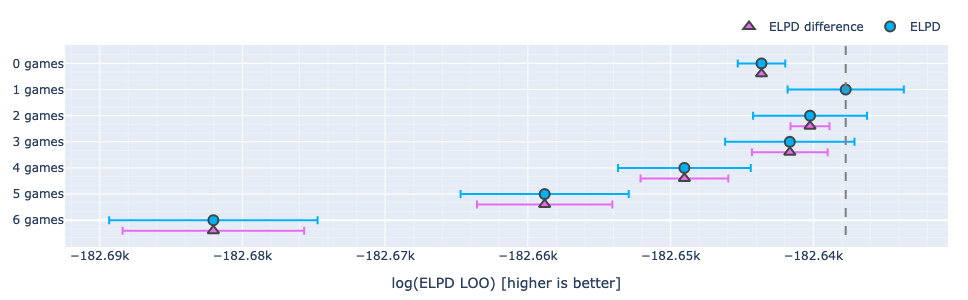

In [6]:
from leaguedata.plot import plot_compare_plotly

plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/true_data_compare_results.json');

/opt/mamba/lib/python3.12/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




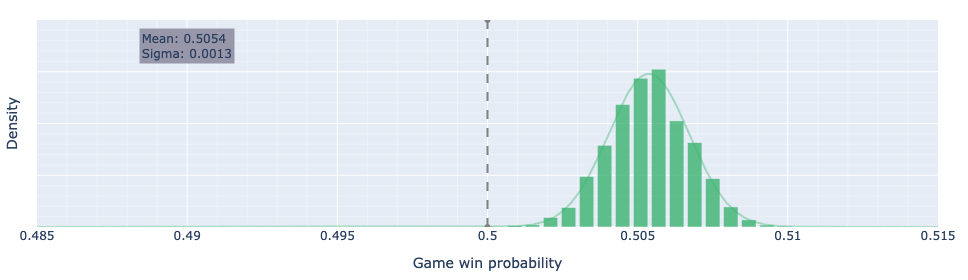

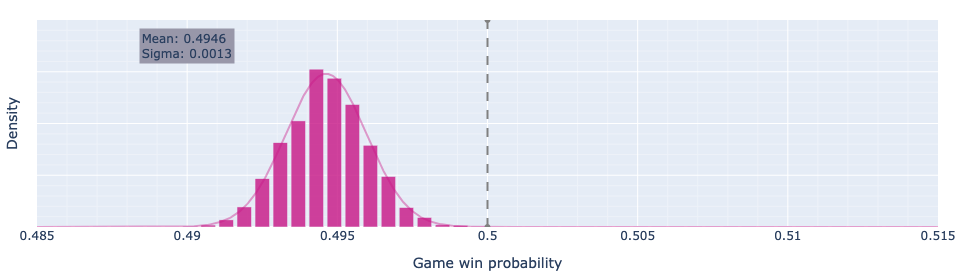

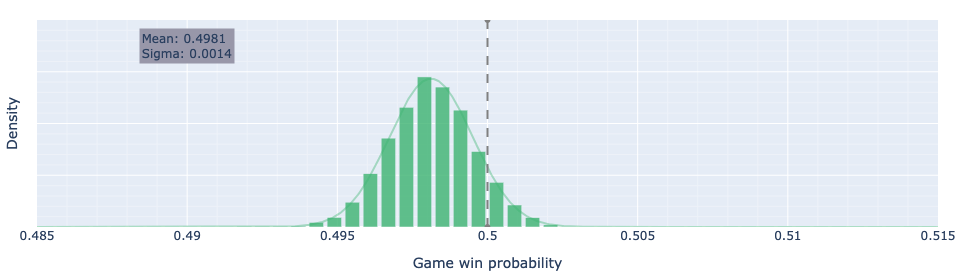

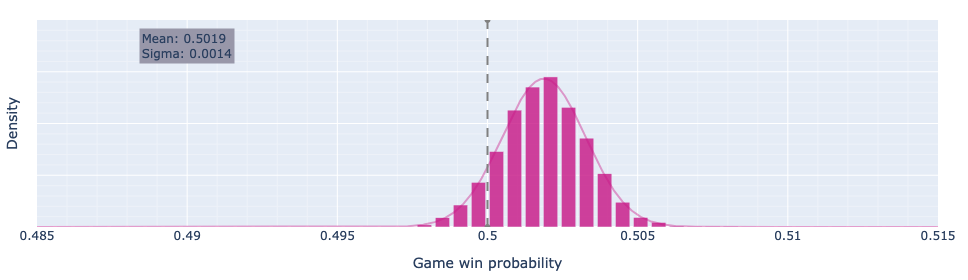

In [8]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm

results = np.asarray(az.extract(best_id).proba)
data1 = results[1] # W>W
data2 = 1 - results[1] # W>L
data3 = results[0] #L>W
data4 = 1 - results[0] #W>W

# List of data and colors
data_list = [data1, data2, data3, data4]
titles = ["Winning after winning", "Losing after winning", "Winning after losing", "Losing after losing"]
colors = ['rgba(60, 179, 113, 0.8)',  'rgba(199, 21, 133, 0.8)', 'rgba(60, 179, 113, 0.8)',  'rgba(199, 21, 133, 0.8)']  
colors_density = ['rgba(60, 179, 113, 0.4)',  'rgba(199, 21, 133, 0.4)', 'rgba(60, 179, 113, 0.4)',  'rgba(199, 21, 133, 0.4)']  
x_min, x_max = 0.485, 0.515

for i, (data, color, color_density) in enumerate(zip(data_list, colors, colors_density)):

    fig = go.Figure()#make_subplots(rows=2, cols=2, subplot_titles=titles, shared_xaxes='all', shared_yaxes='all',)
    # Compute histogram
    hist = np.histogram(data, bins=50, range=(x_min, x_max), density=True)
    bins = hist[1]
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Fit a gaussian
    mu, sigma = norm.fit(data)
    pdf = norm.pdf(np.linspace(x_min, x_max, 1000), mu, sigma)

    # Create histogram trace
    hist_trace = go.Bar(x=bin_centers, y=hist[0], showlegend=False, marker_color=color, name=f'Hist {i+1}')
    
    # Create gaussian fit trace
    fit_trace = go.Scatter(x=np.linspace(x_min, x_max, 1000), y=pdf, mode='lines', line=dict(color=color_density),
                           text=[f'Mean: {mu:.2f}<br>Sigma: {sigma:.2f}']*len(bin_centers),
                           hoverinfo='text+x+y')

    ref_trace = go.Line(
        x=[0.5, 0.5], 
        y=[0, 400], 
        line=dict(color="grey", width=2, dash="dash")
    )
    
    # Add traces to the subplot
    fig.add_trace(hist_trace)#, row=row, col=col)
    fig.add_trace(fit_trace)#, row=row, col=col)
    fig.add_trace(ref_trace)#, row=row, col=col)

    # Add annotations for mean and sigma
    annotation = dict(
        x=0.49, y=350, #xref=f'x{i+1}', yref=f'y{i+1}',
        text=f'Mean: {mu:.4f}<br>Sigma: {sigma:.4f}',
        showarrow=False, align='left', bgcolor='#9897a9'
    )
    fig.add_annotation(annotation)

    fig.update_xaxes(range=[x_min, x_max], title='Game win probability', 
        showgrid=True, minor=dict(showgrid=True))
    fig.update_yaxes(range=[0., 400.], showticklabels=False, title='Density', 
        showgrid=True, minor=dict(showgrid=True))
    #fig.update_yaxes(range=[0, 1], dtick=0.2)
    # Update layout
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        #title_text=titles[i], title_x=0.5,
        height=280, width=320, showlegend=False,
    )
    
    # Show plot
    fig.show()
    
    with open(f'docs/loserQ/assets/true_data_transition_probas_{i}.json', "w") as f:
        f.write(fig.to_json())